In [141]:
import os
import numpy as np
from ultralytics import YOLO
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import pandas as pd

In [143]:
# 1. 데이터 준비: 파일명에서 라벨 추출
def extract_label_from_filename(filename):
    """파일명에서 실험실 유형 라벨을 추출"""
    if "chem" in filename.lower():
        return "chem"
    elif "bio" in filename.lower():
        return "bio"
    elif "rad" in filename.lower():
        return "rad"
    else:
        return "unknown"

# 데이터 경로 설정
image_dir = r"C:\Users\windows11\study\path_to_places365\data"
image_files = [f for f in os.listdir(image_dir) if f.endswith(('.jpg', '.png'))]

# 데이터프레임 생성
data = []
for file in image_files:
    label = extract_label_from_filename(file)
    data.append({"image_name": file, "label": label})

# 데이터프레임으로 정리
labels_df = pd.DataFrame(data)


In [144]:
def detect_objects(image_path, model):
    """YOLO 모델로 객체 탐지"""
    results = model(image_path,conf=0.5)  # YOLO 모델 실행
    detected_objects = []
    
    # 결과 확인 및 클래스 이름 매핑
    if results and hasattr(results[0], "boxes") and results[0].boxes:
        for box in results[0].boxes:
            class_id = int(box.cls)  # 클래스 ID
            detected_objects.append(model.names[class_id])  # 클래스 이름 가져오기
    else:
        detected_objects.append("no_objects_detected")
    
    return detected_objects

# YOLO 모델 로드
yolo_model = YOLO(r"C:\Users\windows11\Downloads\CBR LNP.v1i.yolov8\YOLOv8_training\experiment19\weights\best.pt")

# 탐지 결과 저장
detected_objects_list = []
for image_name in labels_df['image_name']:
    image_path = os.path.join(image_dir, image_name)
    detected_objects = detect_objects(image_path, yolo_model)
    detected_objects_list.append(", ".join(detected_objects))
    
labels_df['detected_objects'] = detected_objects_list    
# 탐지 결과에 "no_objects_detected" 포함된 행 제거
labels_df = labels_df[~labels_df['detected_objects'].str.contains("no_objects_detected", na=False)]

# 필터링 상태 확인
print("필터링 후 데이터프레임:")
print(labels_df[labels_df['detected_objects'].str.contains("no_objects_detected", na=False)])


image 1/1 C:\Users\windows11\study\path_to_places365\data\aug_radio (1).jpg: 352x640 1 lab_animal, 32.2ms
Speed: 4.0ms preprocess, 32.2ms inference, 3.0ms postprocess per image at shape (1, 3, 352, 640)

image 1/1 C:\Users\windows11\study\path_to_places365\data\aug_radio (10).jpg: 352x640 2 manipulation_arms, 31.3ms
Speed: 4.0ms preprocess, 31.3ms inference, 2.0ms postprocess per image at shape (1, 3, 352, 640)

image 1/1 C:\Users\windows11\study\path_to_places365\data\aug_radio (100).jpg: 384x640 (no detections), 36.2ms
Speed: 3.0ms preprocess, 36.2ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 C:\Users\windows11\study\path_to_places365\data\aug_radio (101).jpg: 384x640 (no detections), 20.0ms
Speed: 5.0ms preprocess, 20.0ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 C:\Users\windows11\study\path_to_places365\data\aug_radio (102).jpg: 384x640 1 emergency_shower, 6.5ms
Speed: 1.0ms preprocess, 6.5ms inference, 1.0ms post

In [ ]:
import os
import shutil
import cv2

def detect_objects_and_save(image_path, model, output_dir):
    """YOLO 모델로 객체 탐지 및 표시된 이미지 저장"""
    results = model(image_path)  # YOLO 모델 실행
    detected_objects = []

    # 결과 확인 및 클래스 이름 매핑
    if results and hasattr(results[0], "boxes") and results[0].boxes:
        for box in results[0].boxes:
            class_id = int(box.cls)  # 클래스 ID
            detected_objects.append(model.names[class_id])  # 클래스 이름 가져오기

        # 결과 이미지 저장
        result_image_path = os.path.join(output_dir, os.path.basename(image_path))
        annotated_image = results[0].plot()  # 탐지 결과 시각화
        cv2.imwrite(result_image_path, annotated_image)  # 이미지를 저장
        print(f"탐지 결과 이미지 저장: {result_image_path}")
    else:
        detected_objects.append("no_objects_detected")
        # 원본 이미지를 복사
        shutil.copy(image_path, os.path.join(output_dir, os.path.basename(image_path)))
        print(f"탐지되지 않은 이미지를 저장: {os.path.join(output_dir, os.path.basename(image_path))}")

    return detected_objects

# YOLO 모델 로드
yolo_model = YOLO(r"C:\Users\windows11\Downloads\CBR LNP.v1i.yolov8\YOLOv8_training\experiment19\weights\best.pt")

# 탐지 결과 저장 및 표시된 이미지 복사
output_dir = r"C:\Users\windows11\study\path_to_places365\result"  # 결과 이미지를 저장할 디렉토리
os.makedirs(output_dir, exist_ok=True)

detected_objects_list = []
for image_name in labels_df['image_name']:
    image_path = os.path.join(image_dir, image_name)
    detected_objects = detect_objects_and_save(image_path, yolo_model, output_dir)
    detected_objects_list.append(", ".join(detected_objects))
    
# 탐지 결과에 "no_objects_detected" 포함된 행 제거
labels_df = labels_df[~labels_df['detected_objects'].str.contains("no_objects_detected", na=False)]

# 필터링 상태 확인
print("필터링 후 데이터프레임:")
print(labels_df[labels_df['detected_objects'].str.contains("no_objects_detected", na=False)])


In [145]:
from sklearn.feature_extraction.text import TfidfVectorizer

# 사용자 정의 불용어 리스트 생성
custom_stop_words = ['no_objects_detected']

# TfidfVectorizer 초기화 시 사용자 정의 불용어 리스트 적용
vectorizer = TfidfVectorizer(max_features=20,min_df=0.01, max_df=0.85, stop_words=custom_stop_words)

# 데이터프레임에서 'no_objects_detected' 제거
labels_df = labels_df[labels_df['detected_objects'] != 'no_objects_detected']

# TF-IDF 벡터 생성
tfidf_features = vectorizer.fit_transform(labels_df['detected_objects']).toarray()

# TF-IDF 특징 목록 출력
print("TF-IDF 특징 목록:")
print(vectorizer.get_feature_names_out())


TF-IDF 특징 목록:
['cell_culture' 'centrifuge' 'chromatography_equipment' 'emergency_shower' 'glass_apparatus' 'lab_animal' 'laboratory_chemicals' 'manipulation_arm' 'microscope' 'pcr' 'radiation_hazard_symbol' 'radioactive_hot_cell']


In [146]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# 4. 데이터셋 분리
X_train, X_test, y_train, y_test = train_test_split(
    tfidf_features, 
    labels_df['label'], 
    test_size=0.2, 
    random_state=42
)

# 5. Random Forest 분류기 학습
classifier = RandomForestClassifier(n_estimators=100, random_state=42)
classifier.fit(X_train, y_train)

# 6. 평가
y_pred = classifier.predict(X_test)
print("분류 성능 보고서:")
print(classification_report(y_test, y_pred))

# 예시: 새로운 이미지로 실험실 분류
new_image_path = r"C:\Users\windows11\study\path_to_places365\chem\chemistry_lab\00002977.jpg"
predicted_lab, detected_objects = classify_lab(new_image_path, yolo_model, vectorizer, classifier)
print(f"탐지된 객체: {', '.join(detected_objects)}")
print(f"예측된 실험실 유형: {predicted_lab}")


분류 성능 보고서:
              precision    recall  f1-score   support

         bio       0.45      0.22      0.29        23
        chem       0.61      0.75      0.68        36
         rad       0.69      0.79      0.73        28

    accuracy                           0.62        87
   macro avg       0.59      0.58      0.57        87
weighted avg       0.60      0.62      0.59        87


image 1/1 C:\Users\windows11\study\path_to_places365\chem\chemistry_lab\00002977.jpg: 640x640 2 laboratory_chemicalss, 63.8ms
Speed: 6.0ms preprocess, 63.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)
탐지된 객체: laboratory_chemicals, laboratory_chemicals
예측된 실험실 유형: chem


In [148]:
def classify_lab(image_path, model, vectorizer, classifier, confidence_threshold=0.6):
    """이미지 경로를 받아 실험실 유형을 예측하고 탐지된 객체도 반환 (신뢰도 기반)"""
    # YOLO로 객체 탐지
    detected_objects = detect_objects(image_path, model)
    detected_objects_str = ", ".join(detected_objects)
    
    # TF-IDF 벡터화
    tfidf_vector = vectorizer.transform([detected_objects_str]).toarray()
    
    # Random Forest로 실험실 분류 확률 계산
    lab_probabilities = classifier.predict_proba(tfidf_vector)[0]
    max_probability = max(lab_probabilities)
    
    # 신뢰도 임계값 기반 결과 조정
    if max_probability >= confidence_threshold:
        lab_type = classifier.classes_[lab_probabilities.argmax()]  # 신뢰도가 높은 클래스
    else:
        lab_type = "unknown"  # 신뢰도가 낮으면 "unknown"

    # 탐지된 객체와 예측된 실험실 유형 반환
    return lab_type, detected_objects


In [149]:
new_image_path = r"C:\Users\windows11\study\path_to_places365\bio\biology_laboratory\00001856.jpg"
predicted_lab = classify_lab(new_image_path, yolo_model, vectorizer, classifier)
print(f"예측된 실험실 유형: {predicted_lab}")



image 1/1 C:\Users\windows11\study\path_to_places365\bio\biology_laboratory\00001856.jpg: 640x640 (no detections), 62.6ms
Speed: 8.5ms preprocess, 62.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)
예측된 실험실 유형: ('rad', ['no_objects_detected'])


In [152]:
def classify_lab_from_frame(frame, model, vectorizer, classifier):
    """프레임 데이터를 받아 YOLO 객체 탐지 및 실험실 유형 예측"""
    # YOLO로 객체 탐지
    results = model(frame)
    detected_objects = []
    
    # YOLO 탐지 결과 처리
    if results and hasattr(results[0], "boxes") and results[0].boxes:
        for box in results[0].boxes:
            class_id = int(box.cls)
            detected_objects.append(model.names[class_id])
    else:
        # 탐지 결과가 없으면 "unknown" 반환
        return "unknown", []

    # 탐지된 객체 리스트를 문자열로 변환
    detected_objects_str = ", ".join(detected_objects)

    # TF-IDF 변환 및 실험실 유형 예측
    tfidf_vector = vectorizer.transform([detected_objects_str]).toarray()
    predicted_lab = classifier.predict(tfidf_vector)[0]
    
    return predicted_lab, detected_objects


In [153]:
import cv2

def process_video_realtime(video_path, model, vectorizer, classifier):
    """실시간 캠 영상 또는 동영상을 처리하여 장면 인식 수행"""
    # 동영상 또는 웹캠 입력 열기
    cap = cv2.VideoCapture(0 if video_path == "0" else video_path)

    # 프레임 처리
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # YOLO와 분류 수행
        predicted_lab, detected_objects = classify_lab_from_frame(frame, model, vectorizer, classifier)

        # 탐지된 객체와 예측된 실험실 유형 출력
        print(f"탐지된 객체: {', '.join(detected_objects)}")
        print(f"예측된 실험실 유형: {predicted_lab}")

        # 출력 영상에 결과 렌더링
        cv2.putText(frame, f"Lab: {predicted_lab}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
        cv2.putText(frame, f"Objects: {', '.join(detected_objects)}", (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)
        cv2.imshow('Real-time Scene Recognition', frame)

        # 종료 조건
        if cv2.waitKey(1) & 0xFF == ord('q'):  # 'q'를 눌러 종료
            break

    # 자원 해제
    cap.release()
    cv2.destroyAllWindows()

# 실시간 캠 실행
video_path = r"C:\Users\windows11\Downloads\123.mp4"
process_video_realtime(video_path, yolo_model, vectorizer, classifier)  # "0"은 웹캠 입력


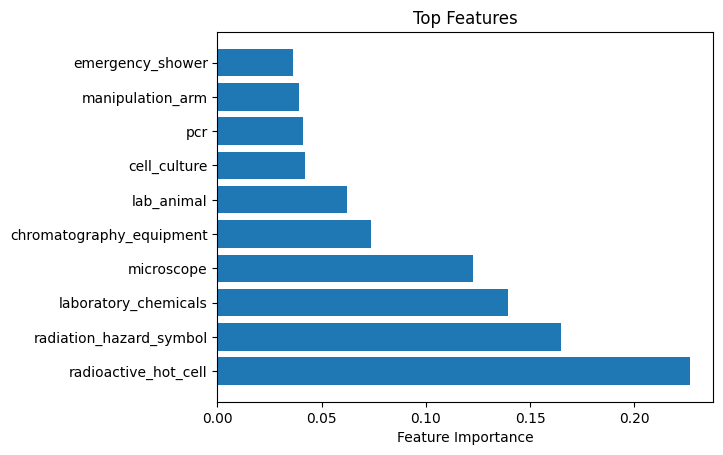

In [154]:
# Random Forest에서 특징 중요도 출력
import matplotlib.pyplot as plt
import numpy as np

feature_importances = classifier.feature_importances_
features = vectorizer.get_feature_names_out()

# 상위 10개 중요한 특징 출력
indices = np.argsort(feature_importances)[::-1][:10]
plt.barh(range(len(indices)), feature_importances[indices])
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Feature Importance')
plt.title('Top Features')
plt.show()


In [155]:
import pandas as pd

# TF-IDF 결과를 데이터프레임으로 정리
tfidf_df = pd.DataFrame(tfidf_features, columns=vectorizer.get_feature_names_out())
tfidf_df['image_name'] = labels_df['image_name']
tfidf_df['label'] = labels_df['label']

# 열 순서 조정
columns_order = ['image_name', 'label'] + list(vectorizer.get_feature_names_out())
tfidf_df = tfidf_df[columns_order]

# 데이터프레임 출력
print(tfidf_df.to_string(index=False))


         image_name label  cell_culture  centrifuge  chromatography_equipment  emergency_shower  glass_apparatus  lab_animal  laboratory_chemicals  manipulation_arm  microscope      pcr  radiation_hazard_symbol  radioactive_hot_cell
  aug_radio (1).jpg   rad           0.0         0.0                  0.000000          0.000000         0.000000    1.000000              0.000000          0.000000    0.000000 0.000000                      0.0              0.000000
 aug_radio (10).jpg   rad           0.0         0.0                  0.000000          0.000000         0.000000    0.000000              0.000000          1.000000    0.000000 0.000000                      0.0              0.000000
                NaN   NaN           0.0         0.0                  0.000000          1.000000         0.000000    0.000000              0.000000          0.000000    0.000000 0.000000                      0.0              0.000000
                NaN   NaN           0.0         1.0                 

랜덤 포레스트 특징 중요도:
                     Feature  Importance
11      radioactive_hot_cell    0.226648
10   radiation_hazard_symbol    0.164975
6       laboratory_chemicals    0.139548
8                 microscope    0.122726
2   chromatography_equipment    0.073720
5                 lab_animal    0.062230
0               cell_culture    0.041798
9                        pcr    0.041022
7           manipulation_arm    0.038899
3           emergency_shower    0.036236
1                 centrifuge    0.028664
4            glass_apparatus    0.023535


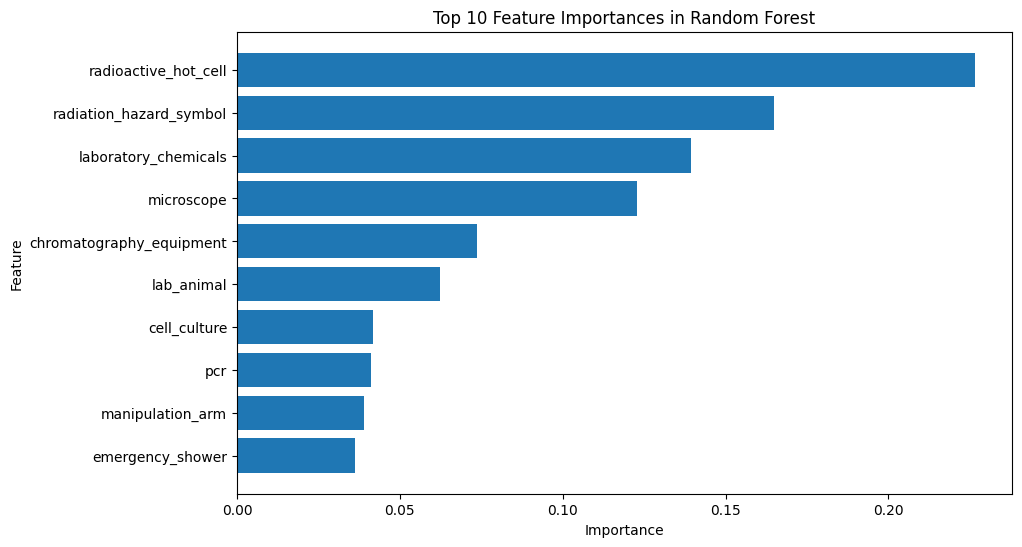

In [156]:
import matplotlib.pyplot as plt
import numpy as np

# 랜덤 포레스트 중요도 추출
feature_importances = classifier.feature_importances_
features = vectorizer.get_feature_names_out()

# 중요도를 데이터프레임으로 정리
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# 중요도 출력
print("랜덤 포레스트 특징 중요도:")
print(importance_df)

# 상위 10개 중요도 시각화
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'][:10], importance_df['Importance'][:10])
plt.gca().invert_yaxis()
plt.title("Top 10 Feature Importances in Random Forest")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()


In [157]:
# 라벨별로 데이터를 그룹화
labels = labels_df['label'].unique()

for label in labels:
    # 특정 라벨에 해당하는 데이터 선택
    indices = labels_df['label'] == label
    tfidf_subset = tfidf_features[indices]

    # 라벨별 평균 TF-IDF 벡터 계산
    mean_tfidf = np.mean(tfidf_subset, axis=0)
    mean_tfidf_df = pd.DataFrame({
        'Feature': vectorizer.get_feature_names_out(),
        'Mean_TFIDF': mean_tfidf
    }).sort_values(by='Mean_TFIDF', ascending=False)

    print(f"\n라벨 '{label}'의 주요 TF-IDF 특징:")
    print(mean_tfidf_df.head(10))



라벨 'rad'의 주요 TF-IDF 특징:
                     Feature  Mean_TFIDF
11      radioactive_hot_cell    0.497541
10   radiation_hazard_symbol    0.172131
5                 lab_animal    0.120231
7           manipulation_arm    0.104938
2   chromatography_equipment    0.032787
3           emergency_shower    0.024590
1                 centrifuge    0.016393
9                        pcr    0.016393
6       laboratory_chemicals    0.008197
0               cell_culture    0.000000

라벨 'bio'의 주요 TF-IDF 특징:
                     Feature  Mean_TFIDF
8                 microscope    0.173492
2   chromatography_equipment    0.164948
6       laboratory_chemicals    0.119172
7           manipulation_arm    0.101558
5                 lab_animal    0.092784
9                        pcr    0.087885
11      radioactive_hot_cell    0.082474
0               cell_culture    0.061856
3           emergency_shower    0.051546
1                 centrifuge    0.030928

라벨 'chem'의 주요 TF-IDF 특징:
                     F